PROJECT 2: Data Mining: fake news detection within online social media


### 

for the slides presentation: https://www.youtube.com/watch?v=cEQXTsZrf8g


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize

from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# dataset 
# we will be using the  buzz feed news  on twitter as dataset

# What we plan on doing is to predict if a news is fake or real based on the words in the title and the text content (body)/ 
# then, what we want to do is give more weight to the words in the title and redo the process, 
# using random forest algorithms




In [4]:
# loading dataset: we have real and fake one
df_real=pd.read_csv('BuzzFeed_real_news_content.csv')
print(df_real.shape)
df_fake=pd.read_csv('BuzzFeed_fake_news_content.csv')
print(df_fake.shape)

(91, 12)
(91, 12)


In [5]:
# let's add the type of news in each dataset
df_real["type"]='real'
df_fake["type"]='fake'

In [6]:
# concatenating the two dataframes
data = pd.concat([df_fake,df_real], axis =0)
print(data.shape)
data.head(4)

(182, 13)


,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,type
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ...",fake
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis...",fake
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi...",fake
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ...",fake


In [7]:
# data summary 
data.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,type
count,182,182,182,174,172,141,174,133,25,172,170,182,182
unique,182,178,178,171,166,90,28,118,25,169,168,171,2
top,Fake_46-Webpage,Clinton Foundation Spent 5.7% on Charity; Rest...,Back when the news first broke about the pay-t...,http://eaglerising.com/36847/clinton-foundatio...,http://static.politico.com/da/f5/44342c424c68b...,Terresa Monroe-hamilton,http://politi.co,{'$date': 1474588800000},https://www.youtube.com/embed/D0DMOBBOJ0U,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,{},real
freq,1,2,2,2,3,8,32,5,1,2,2,8,91


In [8]:
# we can already see that among the titles, there are 5 duplicates
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 90
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              182 non-null    object
 1   title           182 non-null    object
 2   text            182 non-null    object
 3   url             174 non-null    object
 4   top_img         172 non-null    object
 5   authors         141 non-null    object
 6   source          174 non-null    object
 7   publish_date    133 non-null    object
 8   movies          25 non-null     object
 9   images          172 non-null    object
 10  canonical_link  170 non-null    object
 11  meta_data       182 non-null    object
 12  type            182 non-null    object
dtypes: object(13)
memory usage: 19.9+ KB


In [9]:
# cleaning the data and extracting features:
# stop words, tokenization and stemming
# start by removing the columns we are not going to use in our process; we will keep the title, text, the source, image and movie

data.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1, inplace=True)

# checking missing and null values
print(data.isnull().sum())
print(data.isna().sum())



title       0
text        0
source      8
movies    157
images     10
type        0
dtype: int64
title       0
text        0
source      8
movies    157
images     10
type        0
dtype: int64


In [10]:
# so we have 157 NA in movie column and some in source and images; this is coherent with the data.info()
# we might just end up, droping this movie column, as it has so many NAN, another alternative is
# we will transform the image and movie column into new binary columns depending on if the earticle has contain an image or
# and similarly,  if the link to a movie is available or not

data['movies']=data['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)
data['images']=data['images'].apply(lambda x: 0 if str(x)=='nan' else 1)

data.head(5)


,title,text,source,movies,images,type
0,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org,0,1,fake
1,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com,0,1,fake
2,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com,0,1,fake
3,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org,0,1,fake
4,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com,0,0,fake


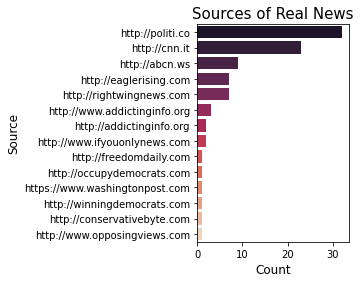

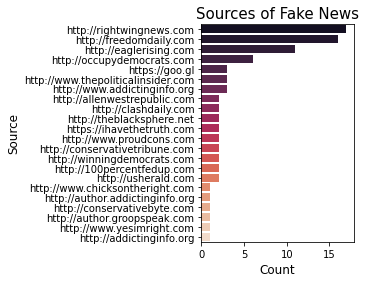

In [11]:
# now, let"s look at the source and see the difference between the real and fake sources
real_order=data[data['type']=='real']['source'].value_counts().sort_values(ascending=False).index
fake_order=data[data['type']=='fake']['source'].value_counts().sort_values(ascending=False).index

# subplot for the real sources
plt.subplot(1, 2, 1) 
#plt.figure(figsize=(10,6))
sns.countplot(y='source', data=data[data['type']=='real'],order=real_order,palette='rocket')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

# subplot for the fake sources
plt.subplot(1, 2, 2) 
#plt.figure(figsize=(10,6))
sns.countplot(y='source', data=data[data['type']=='fake'],order=fake_order,palette='rocket')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=15)

plt.show()


In [12]:
#data[data['type']=='fake']['source'].unique()

In [13]:
# let's check the sources that publish both fake and real news
both_sources =[]
for i in data[data['type']=='fake']['source'].unique():
    if i in data[data['type']=='real']['source'].unique():
        both_sources.append(i)

print(both_sources)

['http://www.addictinginfo.org', 'http://eaglerising.com', 'http://conservativebyte.com', 'http://winningdemocrats.com', 'http://freedomdaily.com', 'http://occupydemocrats.com', 'http://rightwingnews.com', 'http://addictinginfo.org']


In [14]:
# let's plot the common sources with their ratio of real and fake news:
data['common']= data['source'].apply(lambda x: x if x in both_sources else 0 )

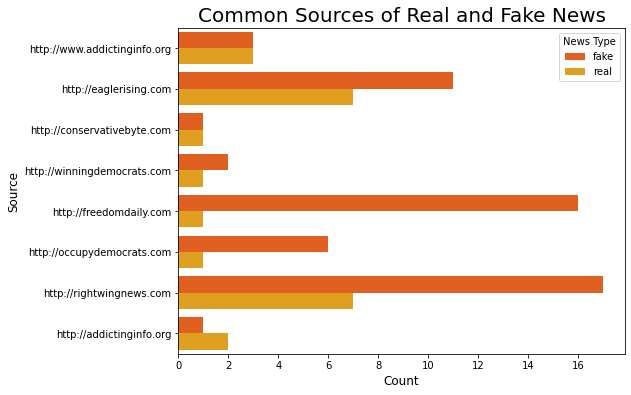

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(y='common',data=data[data['common']!=0],hue='type',palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

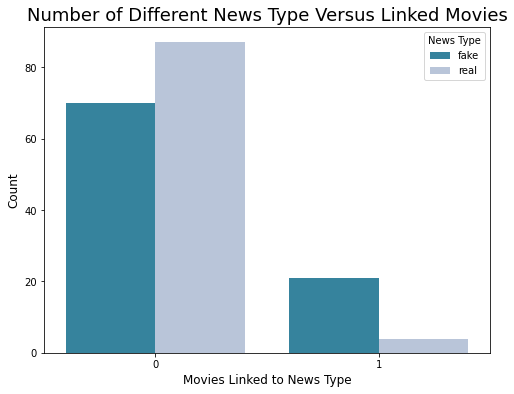

In [16]:
# let's look at the number of sources including a movie vs not
plt.figure(figsize=(8,6))
sns.countplot(x='movies', data=data, hue='type', palette='PuBuGn_r')
plt.xlabel('Movies Linked to News Type',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Movies',fontsize=18)
plt.show()

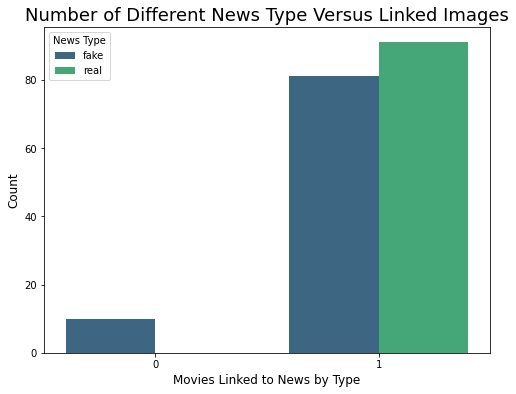

In [211]:
# most news does not have movie clips incorporated, we might end up dropping this column, as it does not provide useful info
# let's see for the images
plt.figure(figsize=(8,6))
sns.countplot(x='images', data=data, hue='type', palette='viridis')
plt.xlabel('Movies Linked to News by Type',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Number of Different News Type Versus Linked Images',fontsize=18)
plt.show()

In [18]:
# this shows that all real news contain images as well as some fake ones. this could be some useful info


In [19]:
# preprocessing of the title and text of news articles....
# For this, we are going to :
 # convert text to lower case
 # remove numbern punctuation, extra spaces, special characters from the text corpus
 # removing stop words
 # stemming words to root


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
# preprocessing function:

ps = PorterStemmer()
wt = WhitespaceTokenizer()

def preprocess_text(text):
    
    #text = ''
    #removing the stopwords
    
    #wordlist = word_tokenize(x)
    
    wordlist = word_tokenize(text)
    #print(wordlist)
    
    # lower
    text = [ word.lower() for word in wordlist]
    
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords$
    stop_words.extend(nltk_words)
    filtered_words = [word for word in text if word not in stop_words]
    #print(filtered_words)
    
    
    # removing special char 
    text = [word for word in filtered_words if (word.isalnum()==True) or (word==' ') ] 
    #print(text)
    
    #removing special characters and punctuation
    #text = text.translate(str.maketrans('', '', string.punctuation))
    #text = [word for word in text if word not in string.punctuation]
    #text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]
    text = [word for word in text if word not in string.punctuation]
    #text2 = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]
    #wordlist = word_tokenize(text)
    
    #REMOVING NUMBERS
    text = str(' ').join([i for i in text if not i.isdigit()])
    
    
    
    
    #for sentence in intext:
    #    text = text+' '+sentence
    
    #print(text)
    # stemming the input words:
    #psstem = [ps.stem(a) for a in text]
    psstem = ps.stem(text)
    #text = ' '.join(psstem)
     
    # removing spaces and getting only words:
    text = wt.tokenize(psstem)
    #print(text)
     
    
    
    
    
    
    #print(text)
    # lower case
    out = ''
    for word in text:
        out = out+word.lower()+' '
    #text = [ word.lower() for word in text]
    #text = text.lower() 
    
    # print (out)
    
    return out



In [25]:
test = ['Proof The Mainstream Media Is Manipulating The Election By Taking Bill Clinton Out Of Context']

In [26]:
a=[]

for line in test:
    a.append(preprocess_text(line))

#a

In [27]:
# getting the count per words given the dataset:
def count_words(dataset):
    
    # preprocessing the dataset
    dat_tit =[]
    for line in dataset:
        dat_tit.append(preprocess_text(line))
    
    # vectorising the output by wounts
    countvect = CountVectorizer( ).fit( dat_tit)
    df_title = countvect.transform(dat_tit)
    print(pd.DataFrame(df_title.todense()).shape)
    
    # getting the sum for each word
    new1=[]
    for x in range(0,pd.DataFrame(df_title.todense()).shape[1]):
        new1.append(countvect.get_feature_names()[x])

    # tdf matrix
    matrix=pd.DataFrame(df_title.todense(),columns=new1)

    # sum for representation
    sm1=[]
    for x in new1:
        sm1.append(matrix[x].sum())

    trans=matrix.transpose()
    trans['sum']=sm1
    top=trans.sort_values(by='sum', ascending=False)
    
    return top
    
    
    
    

In [28]:
# analysze title of fake and real news
# here, the goal is to bring out the firsr top 25 topics of the different articles in their titles

# fake
df_fake=data[data['type']=='fake']

print(df_fake['title'].shape)
#type(df_fake['title'])

top_fake_20=count_words(df_fake['title']).head(20)

(91,)
(91, 464)


/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# for the real dataqet

df_real=data[data['type']=='real']

print(df_real['title'].shape)
#type(df_fake['title'])

top_real_20=count_words(df_real['title']).head(20)

(91,)
(91, 442)


In [30]:
# merging the fake and real top 20

#let's drop the useless columns, those not the sum
top_fake_20.drop(list(range(0,91)),axis=1,inplace=True)
top_real_20.drop(list(range(0,91)),axis=1,inplace=True)

# adding a category column
top_real_20['type']='real'
top_fake_20['type']='fake'


In [31]:
# concat
conc1_top_20=pd.concat([top_real_20,top_fake_20])

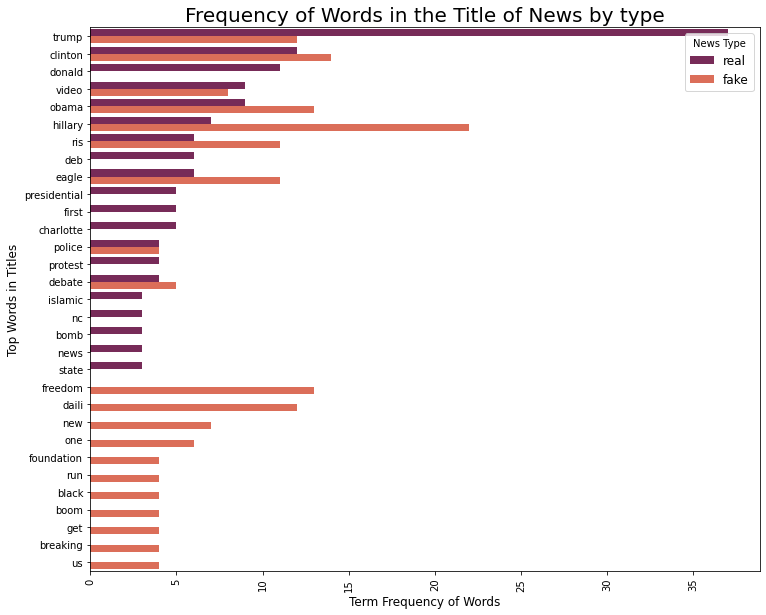

In [32]:
# let's plot them
plt.figure(figsize=(12,10))
sns.barplot(y=conc1_top_20.index,x='sum',data=conc1_top_20,hue='type',palette='rocket')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News by type',fontsize=20)
plt.show()

In [215]:
# let's do the same process for the body of real and fake top 30

# for the real dataqet
print("real")
print(df_real['text'].shape)
#type(df_fake['title'])

top_Breal_30=count_words(df_real['text']).head(20)

# for the fake dataqet
print ("fake")
print(df_fake['text'].shape)
#type(df_fake['title'])

top_Bfake_30=count_words(df_fake['text']).head(20)

real
(91,)
(91, 7115)
fake
(91,)
(91, 5564)


In [213]:
# merging the fake and real top 20

#let's drop the useless columns, those not the sum
top_Bfake_30.drop(list(range(0,91)),axis=1,inplace=True)
top_Breal_30.drop(list(range(0,91)),axis=1,inplace=True)

# adding a category column
top_Breal_30['type']='real'
top_Bfake_30['type']='fake'
# concat
conc1_top_20_b=pd.concat([top_Breal_30,top_Bfake_30])

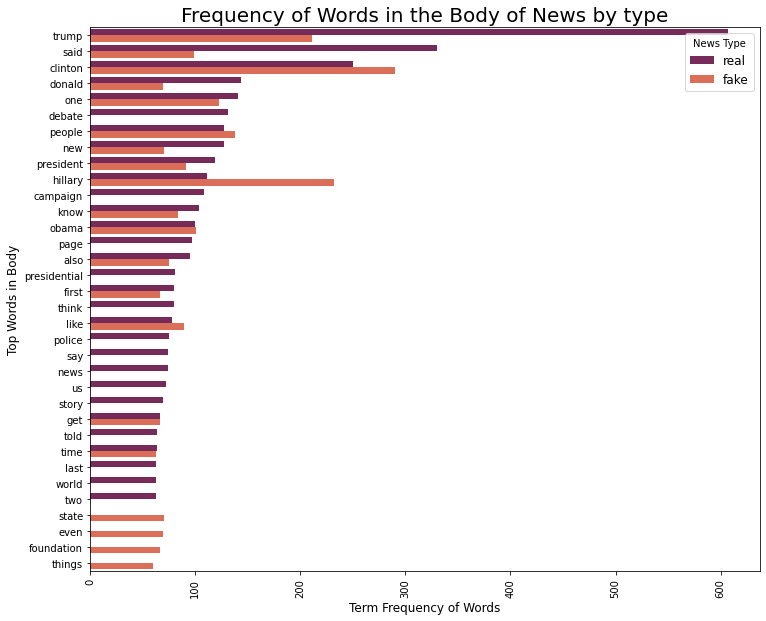

In [214]:
# let's plot them
plt.figure(figsize=(12,10))
sns.barplot(y=conc1_top_20_b.index,x='sum',data=conc1_top_20_b,hue='type',palette='rocket')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Body',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Body of News by type',fontsize=20)
plt.show()

In [37]:
# let's analyse the length of the title and body text
data['title_length']=data['title'].apply(lambda x: len(x))
data['body_length']=data['text'].apply(lambda x: len(x))

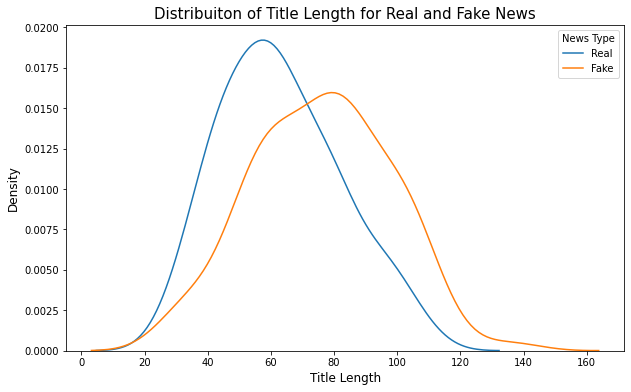

In [38]:
# plotting title length
plt.figure(figsize=(10,6))
sns.kdeplot(data[data['type']=='real']['title_length'])
sns.kdeplot(data[data['type']=='fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

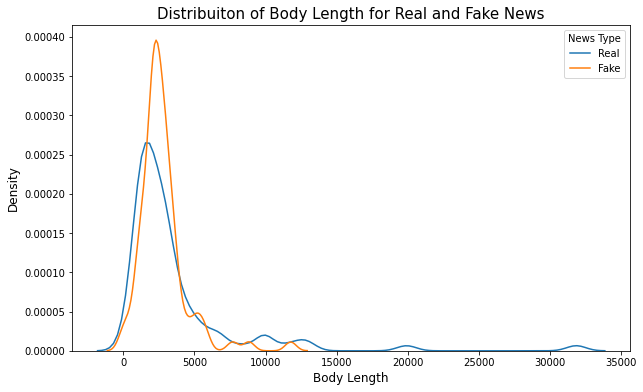

In [39]:
# plotting title length
plt.figure(figsize=(10,6))
sns.kdeplot(data[data['type']=='real']['body_length'])
sns.kdeplot(data[data['type']=='fake']['body_length'])
plt.xlabel('Body Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Body Length for Real and Fake News',fontsize=15)
plt.show()

### Classification
#### Random Forest with the tdf of the body only

In [40]:
yb= data['type']

In [41]:
Xb= [preprocess_text(line)for line in data['text']]


In [42]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=0)

In [209]:
print(len(Xb_train),len(yb_train), len(Xb_test), len(yb_test) )

127 127 55 55


In [43]:
def pipeL_rf():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier())
        ])
    return pp


In [50]:
pp=pipeL_rf()
pp.fit(Xb_train,yb_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [51]:
# predicting the articles in the test set
predictions1=pp.predict(Xb_test)

In [52]:
print(confusion_matrix(yb_test, predictions1))
print('\n')
print(classification_report(yb_test, predictions1))

[[22  6]
 [ 5 22]]


              precision    recall  f1-score   support

        fake       0.81      0.79      0.80        28
        real       0.79      0.81      0.80        27

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


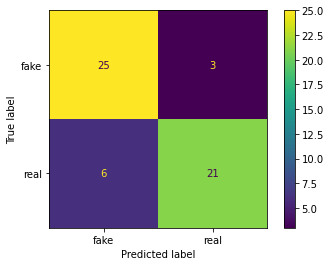

In [518]:
plot_confusion_matrix(pp, Xb_test, yb_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.75      0.86      0.80        28
        real       0.83      0.70      0.76        27

    accuracy                           0.78        55
   macro avg       0.79      0.78      0.78        55
weighted avg       0.79      0.78      0.78        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


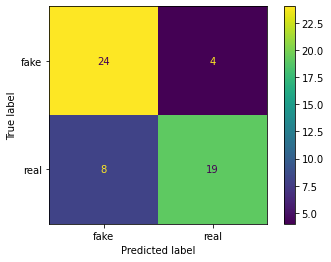

In [57]:
# let's see without text preprocessing
Xb1= data['text']
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(Xb1, yb, test_size=0.3, random_state=0)
# new pipeline instance
pp=pipeL_rf()
pp.fit(Xb1_train,yb1_train)
# predicting the articles in the test set
predictions2=pp.predict(Xb1_test)
print(classification_report(yb1_test, predictions2))
plot_confusion_matrix(pp, Xb1_test, yb1_test)  
plt.show()

In [ ]:
# training the model without preprocessing is giving less accuracy than with pre processing, so we will keep the pre precess
# let's try the prediction based on title only



In [58]:

yt=data['type']
Xt= [preprocess_text(line)for line in data['title']]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.3, random_state=0)



In [59]:
pp=pipeL_rf()
pp.fit(Xt_train,yt_train)
predictionstt=pp.predict(Xt_test)

              precision    recall  f1-score   support

        fake       0.83      0.36      0.50        28
        real       0.58      0.93      0.71        27

    accuracy                           0.64        55
   macro avg       0.71      0.64      0.61        55
weighted avg       0.71      0.64      0.61        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


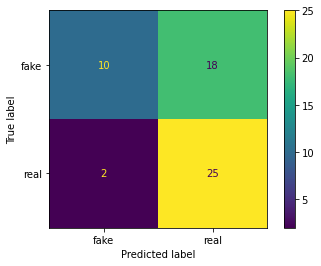

In [60]:

print(classification_report(yt_test, predictionstt))
plot_confusion_matrix(pp, Xt_test, yt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.88      0.50      0.64        28
        real       0.64      0.93      0.76        27

    accuracy                           0.71        55
   macro avg       0.76      0.71      0.70        55
weighted avg       0.76      0.71      0.70        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


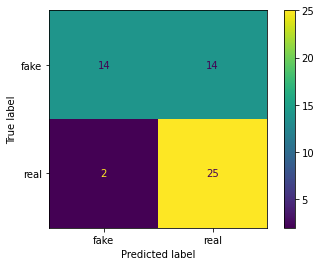

In [61]:
# let's see without text preprocessing
Xt1= data['title']
yt1= data['type']
Xt1_train, Xt1_test, yt1_train, yt1_test = train_test_split(Xt1, yt1, test_size=0.3, random_state=0)
pp=pipeL_rf()
pp.fit(Xt1_train,yt1_train)
# predicting the articles in the test set
predictions2=pp.predict(Xt1_test)
print(classification_report(yt1_test, predictions2))
plot_confusion_matrix(pp, Xt1_test, yt1_test)  
plt.show()

In [147]:
# this is not too good, especially for the fake news that are more classified as real. this can be seen in the recall of fake as well

# ppbt=Pipeline([
#    ('bow',CountVectorizer()),
#    ('tfidf',TfidfTransformer()),
#    ('classifier',RandomForestClassifier())
#    ])

In [62]:
# prediction using both title and body

data['title_text']=data['title']+': ' +data['text']


In [63]:

ybt=data['type']
Xbt= [preprocess_text(line)for line in data['title_text']]
Xbt_train, Xbt_test, ybt_train, ybt_test = train_test_split(Xbt, ybt, test_size=0.3, random_state=0)

              precision    recall  f1-score   support

        fake       0.76      0.93      0.84        28
        real       0.90      0.70      0.79        27

    accuracy                           0.82        55
   macro avg       0.83      0.82      0.82        55
weighted avg       0.83      0.82      0.82        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


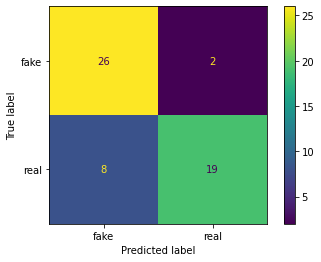

In [66]:

ppbt=pipeL_rf()
ppbt.fit(Xbt_train,ybt_train)
predictionstt=ppbt.predict(Xbt_test)

print(classification_report(ybt_test, predictionstt))
plot_confusion_matrix(ppbt, Xbt_test, ybt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.77      0.71      0.74        28
        real       0.72      0.78      0.75        27

    accuracy                           0.75        55
   macro avg       0.75      0.75      0.75        55
weighted avg       0.75      0.75      0.75        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


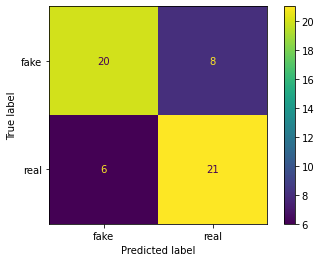

In [108]:
# let's see without text preprocessing
Xbt1= data['title_text']
ybt1= data['type']
Xbt1_train, Xbt1_test, ybt1_train, ybt1_test = train_test_split(Xbt1, ybt1, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt1_train,ybt1_train)
# predicting the articles in the test set
predictions2=ppbt.predict(Xbt1_test)
print(classification_report(ybt1_test, predictions2))
plot_confusion_matrix(ppbt, Xbt1_test, ybt1_test)  
plt.show()

In [77]:
# let's try to predict with a weight of 2 more on the body words

data['title_text2']=': ' +data['title']+data['text']+': ' +data['text']

              precision    recall  f1-score   support

        fake       0.79      0.96      0.87        28
        real       0.95      0.74      0.83        27

    accuracy                           0.85        55
   macro avg       0.87      0.85      0.85        55
weighted avg       0.87      0.85      0.85        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


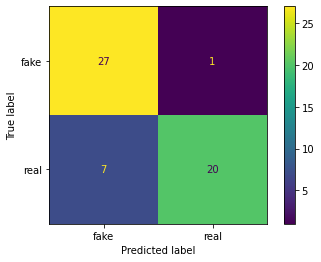

In [78]:
ybt2= data['type']
Xbt2= [preprocess_text(line)for line in data['title_text2']]
Xbt2_train, Xbt2_test, ybt2_train, ybt2_test = train_test_split(Xbt2, ybt2, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt2_train,ybt2_train)
predictionstt=ppbt.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionstt))
plot_confusion_matrix(ppbt, Xbt2_test, ybt2_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.81      0.89      0.85        28
        real       0.88      0.78      0.82        27

    accuracy                           0.84        55
   macro avg       0.84      0.84      0.84        55
weighted avg       0.84      0.84      0.84        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


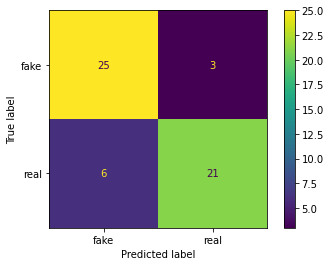

In [107]:
# let's see without text preprocessing
Xbt21= data['title_text2']
ybt21= data['type']
Xbt21_train, Xbt21_test, ybt21_train, ybt21_test = train_test_split(Xbt21, ybt21, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt21_train,ybt21_train)
# predicting the articles in the test set
predictions2=ppbt.predict(Xbt21_test)
print(classification_report(ybt21_test, predictions2))
plot_confusion_matrix(ppbt, Xbt21_test, ybt21_test)  
plt.show()


#### XG boosting classifier


In [82]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost


In [83]:
print(xgboost.__version__)

0.80


In [84]:
# couldn't run the version 1.5; kernel would continuously crash

In [85]:
def pp_xgb(rs=0,ss=0.7):
    xgb = XGBClassifier(random_state=rs, seed=2, colsample_bytree=0.6, subsample=ss)
    ppxg=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier', xgb )
        ])
    return ppxg

In [86]:
#pipeline = Pipeline([
#  ("vectorizer", TfidfVectorizer()),
#  ("classifier", XGBClassifier())
#])

ppxg=pp_xgb()

In [87]:
ppxg.fit(Xt_train,yt_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 XGBClassifier(colsample_bytree=0.6, seed=2, subsample=0.7))])

In [88]:

predictionsxg=ppxg.predict(Xt_test)

              precision    recall  f1-score   support

        fake       0.87      0.46      0.60        28
        real       0.62      0.93      0.75        27

    accuracy                           0.69        55
   macro avg       0.75      0.70      0.68        55
weighted avg       0.75      0.69      0.67        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


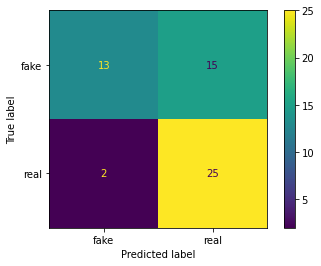

In [89]:
print(classification_report(yt_test, predictionsxg))
plot_confusion_matrix(ppxg, Xt_test, yt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.94      0.54      0.68        28
        real       0.67      0.96      0.79        27

    accuracy                           0.75        55
   macro avg       0.80      0.75      0.73        55
weighted avg       0.80      0.75      0.73        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


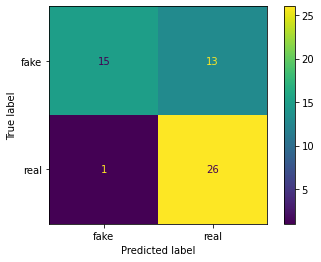

In [109]:
# title without preprocessing
ppxg=pp_xgb()
ppxg.fit(Xt1_train,yt1_train)

predictionsxg=ppxg.predict(Xt1_test)

print(classification_report(yt1_test, predictionsxg))
plot_confusion_matrix(ppxg, Xt1_test, yt1_test)  
plt.show()


              precision    recall  f1-score   support

        fake       0.71      0.79      0.75        28
        real       0.75      0.67      0.71        27

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


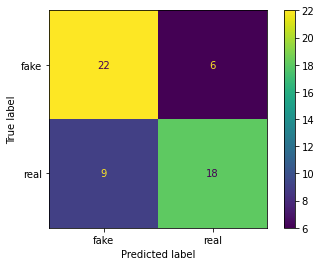

In [90]:
# body dataset PREPROCESSD 
ppxg=pp_xgb()
ppxg.fit(Xb_train,yb_train)

predictionsxg=ppxg.predict(Xb_test)

print(classification_report(yb_test, predictionsxg))
plot_confusion_matrix(ppxg, Xb_test, yb_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.71      0.71      0.71        28
        real       0.70      0.70      0.70        27

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


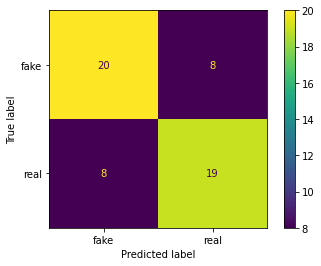

In [110]:
# body dataset Non preprocessed
ppxg=pp_xgb()
ppxg.fit(Xb1_train,yb1_train)

predictionsxg=ppxg.predict(Xb1_test)

print(classification_report(yb1_test, predictionsxg))
plot_confusion_matrix(ppxg, Xb1_test, yb1_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.73      0.79      0.76        28
        real       0.76      0.70      0.73        27

    accuracy                           0.75        55
   macro avg       0.75      0.74      0.74        55
weighted avg       0.75      0.75      0.74        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


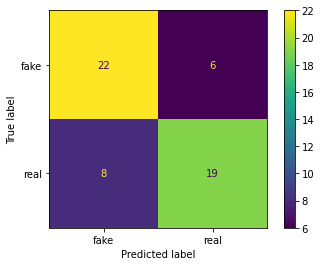

In [91]:
# body and title dataset PREPROCESSED
ppxg=pp_xgb()
ppxg.fit(Xbt_train,ybt_train)

predictionsxg=ppxg.predict(Xbt_test)

print(classification_report(ybt_test, predictionsxg))
plot_confusion_matrix(ppxg, Xbt_test, ybt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.71      0.71      0.71        28
        real       0.70      0.70      0.70        27

    accuracy                           0.71        55
   macro avg       0.71      0.71      0.71        55
weighted avg       0.71      0.71      0.71        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


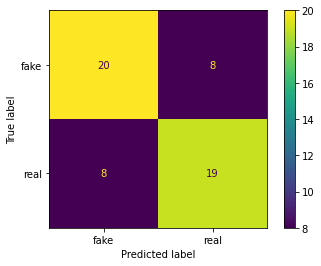

In [111]:
# body and title dataset NON PREPROCESSD
ppxg=pp_xgb()
ppxg.fit(Xbt1_train,ybt1_train)

predictionsxg=ppxg.predict(Xbt1_test)

print(classification_report(ybt1_test, predictionsxg))
plot_confusion_matrix(ppxg, Xbt1_test, ybt1_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.77      0.86      0.81        28
        real       0.83      0.74      0.78        27

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


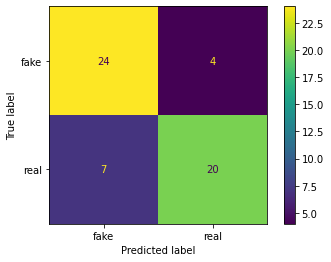

In [112]:
# body and title dataset modified preprocessed
ppxg=pp_xgb()
ppxg.fit(Xbt2_train,ybt2_train)

predictionsxg=ppxg.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionsxg))
plot_confusion_matrix(ppxg, Xbt2_test, ybt2_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.72      0.75      0.74        28
        real       0.73      0.70      0.72        27

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


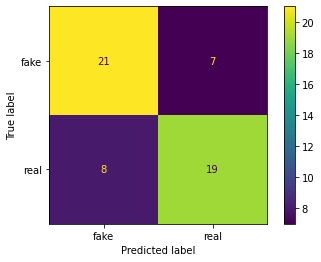

In [113]:
# body and title dataset modified NON preprocessed
ppxg=pp_xgb()
ppxg.fit(Xbt21_train,ybt21_train)

predictionsxg=ppxg.predict(Xbt21_test)

print(classification_report(ybt21_test, predictionsxg))
plot_confusion_matrix(ppxg, Xbt21_test, ybt21_test)  
plt.show()

In [114]:
# tuning parameter:

ppxg.named_steps['classifier'].get_params()


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 2,
 'silent': True,
 'subsample': 0.7}

In [221]:
# those are the base parameters in the xgboost classifier, let's. tune them
# changing the number of estimators
# definition of parameter grid to scan through
param_grid = {
     'classifier__n_estimators': [100,200,300,500],
     'classifier__random_state':[0,42],
     'classifier__colsample_bytree': [0.6],
     'classifier__subsample': [0.5, 0.6, 0.7],
    'classifier__learning_rate':[0.05, 0.01]
}


In [222]:
#
# grid search cross validation instantiation
ppxg=pp_xgb()
grid_search = GridSearchCV(estimator = ppxg, param_grid = param_grid, 
                          cv = 5, n_jobs = 1, verbose = 0, return_train_score=True)
#hyperparameter fitting
grid_search.fit(Xt_train, yt_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        XGBClassifier(colsample_bytree=0.6,
                                                      seed=2,
                                                      subsample=0.7))]),
             n_jobs=1,
             param_grid={'classifier__colsample_bytree': [0.6],
                         'classifier__learning_rate': [0.05, 0.01],
                         'classifier__n_estimators': [100, 200, 300, 500],
                         'classifier__random_state': [0, 42],
                         'classifier__subsample': [0.5, 0.6, 0.7]},
             return_train_score=True)

In [99]:
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

train scores
[0.72642205 0.73622598 0.75600854 0.72642205 0.73622598 0.75600854
 0.75600854 0.77565521 0.7913609  0.75600854 0.77565521 0.7913609
 0.76777325 0.79336051 0.80516405 0.76777325 0.79336051 0.80516405
 0.79922345 0.83071248 0.84059406 0.79922345 0.83071248 0.84059406]
validation scores
[0.54369231 0.58369231 0.61476923 0.54369231 0.58369231 0.61476923
 0.59076923 0.60676923 0.59876923 0.59076923 0.60676923 0.59876923
 0.60646154 0.60676923 0.59876923 0.60646154 0.60676923 0.59876923
 0.59076923 0.59938462 0.59107692 0.59076923 0.59938462 0.59107692]


In [117]:

grid_search.best_params_

{'classifier__colsample_bytree': 0.6,
 'classifier__n_estimators': 100,
 'classifier__random_state': 0,
 'classifier__subsample': 0.7}

              precision    recall  f1-score   support

        fake       0.87      0.46      0.60        28
        real       0.62      0.93      0.75        27

    accuracy                           0.69        55
   macro avg       0.75      0.70      0.68        55
weighted avg       0.75      0.69      0.67        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


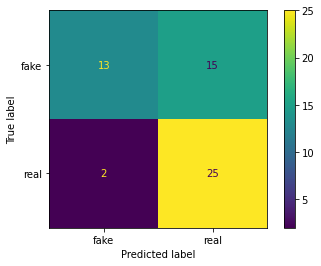

In [118]:
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xt_test)

print(classification_report(yt_test, predictionsxg))
plot_confusion_matrix(ppxg_test, Xt_test, yt_test)  
plt.show()

train scores
[0.99803922 0.99803922 1.         0.99803922 0.99803922 1.
 1.         1.         1.         1.         1.         1.
 0.99803922 1.         1.         0.99803922 1.         1.
 1.         1.         1.         1.         1.         1.        ]
validation scores
[0.72369231 0.70892308 0.72430769 0.72369231 0.70892308 0.72430769
 0.73938462 0.67723077 0.732      0.73938462 0.67723077 0.732
 0.70738462 0.68523077 0.716      0.70738462 0.68523077 0.716
 0.7        0.69292308 0.70830769 0.7        0.69292308 0.70830769]
{'classifier__colsample_bytree': 0.6, 'classifier__n_estimators': 200, 'classifier__random_state': 0, 'classifier__subsample': 0.5}
              precision    recall  f1-score   support

        fake       0.72      0.75      0.74        28
        real       0.73      0.70      0.72        27

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


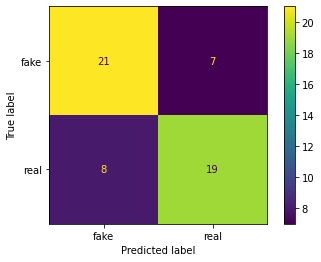

In [119]:
# body data PREPROCEDSSDE

grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting

ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xb_test)

print(classification_report(yb_test, predictionsxg))
plot_confusion_matrix(ppxg_test, Xb_test, yb_test)  
plt.show()

train scores
[0.99803922 0.99803922 1.         0.99803922 0.99803922 1.
 0.99803922 1.         1.         0.99803922 1.         1.
 0.99803922 1.         1.         0.99803922 1.         1.
 0.99803922 1.         1.         0.99803922 1.         1.        ]
validation scores
[0.71630769 0.71661538 0.69261538 0.71630769 0.71661538 0.69261538
 0.68492308 0.69292308 0.70092308 0.68492308 0.69292308 0.70092308
 0.69323077 0.716      0.71630769 0.69323077 0.716      0.71630769
 0.71661538 0.72338462 0.724      0.71661538 0.72338462 0.724     ]
{'classifier__colsample_bytree': 0.6, 'classifier__n_estimators': 500, 'classifier__random_state': 0, 'classifier__subsample': 0.7}
              precision    recall  f1-score   support

        fake       0.67      0.71      0.69        28
        real       0.68      0.63      0.65        27

    accuracy                           0.67        55
   macro avg       0.67      0.67      0.67        55
weighted avg       0.67      0.67      0.67        

/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


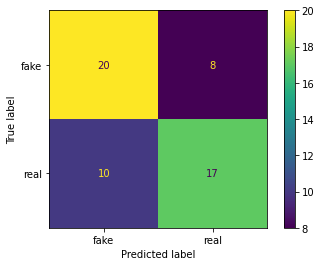

In [121]:
# text and title together PREPROCCESDDES

grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xbt_test)

print(classification_report(ybt_test, predictionsxg))
plot_confusion_matrix(ppxg_test, Xbt_test, ybt_test)  
plt.show()


In [223]:
# text and title modified 

grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionsxg))
#plot_confusion_matrix(ppxg_test, Xbt2_test, ybt2_test)  
#plt.show()


train scores
[0.99803922 0.99803922 0.99803922 0.99803922 0.99803922 0.99803922
 0.99803922 0.99803922 1.         0.99803922 0.99803922 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.95472724 0.95470782 0.95280528 0.95472724 0.95470782 0.95280528
 0.98033392 0.99215686 0.98231411 0.98033392 0.99215686 0.98231411
 0.99211804 0.99411765 0.99803922 0.99211804 0.99411765 0.99803922
 0.99803922 0.99803922 0.99803922 0.99803922 0.99803922 0.99803922]
validation scores
[0.72430769 0.70061538 0.732      0.72430769 0.70061538 0.732
 0.72492308 0.71692308 0.70892308 0.72492308 0.71692308 0.70892308
 0.72461538 0.72492308 0.70092308 0.72461538 0.72492308 0.70092308
 0.70892308 0.72492308 0.70092308 0.70892308 0.72492308 0.70092308
 0.73261538 0.70030769 0.70030769 0.73261538 0.70030769 0.70030769
 0.73230769 0.72430769 0.71630769 0.73230769 0.72430769 0.71630769
 0.732      0.73969231 0.74       0.732      0.73969231 0.7

### PASSIVE Agressive Classifier
LET4s try the classification with the passive aggressive classifier

In [128]:
def pp_pass():
    pp_pa=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',PassiveAggressiveClassifier())
        ])
    return pp_pa

              precision    recall  f1-score   support

        fake       0.71      0.61      0.65        28
        real       0.65      0.74      0.69        27

    accuracy                           0.67        55
   macro avg       0.68      0.67      0.67        55
weighted avg       0.68      0.67      0.67        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


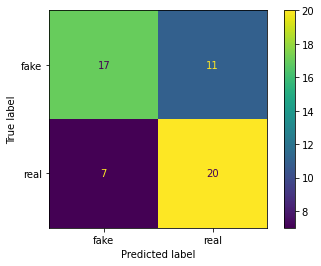

In [129]:
# on the title data preprocssd
pp_pa=pp_pass()
pp_pa.fit(Xt_train,yt_train)
predictionstt=pp_pa.predict(Xt_test)

print(classification_report(yt_test, predictionstt))
plot_confusion_matrix(pp_pa, Xt_test, yt_test)  
plt.show()


              precision    recall  f1-score   support

        fake       0.74      0.71      0.73        28
        real       0.71      0.74      0.73        27

    accuracy                           0.73        55
   macro avg       0.73      0.73      0.73        55
weighted avg       0.73      0.73      0.73        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


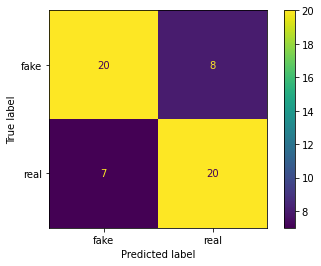

In [130]:
# on the body data
pp_pa=pp_pass()
pp_pa.fit(Xb_train,yb_train)
predictionsbb=pp_pa.predict(Xb_test)

print(classification_report(yb_test, predictionsbb))
plot_confusion_matrix(pp_pa, Xb_test, yb_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.76      0.79      0.77        28
        real       0.77      0.74      0.75        27

    accuracy                           0.76        55
   macro avg       0.76      0.76      0.76        55
weighted avg       0.76      0.76      0.76        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


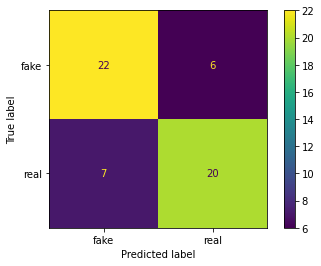

In [132]:
# on the body and title mixed data
pp_pa=pp_pass()
pp_pa.fit(Xbt_train,ybt_train)
predictionsbt=pp_pa.predict(Xbt_test)

print(classification_report(ybt_test, predictionsbt))
plot_confusion_matrix(pp_pa, Xbt_test, ybt_test)  
plt.show()


              precision    recall  f1-score   support

        fake       0.75      0.75      0.75        28
        real       0.74      0.74      0.74        27

    accuracy                           0.75        55
   macro avg       0.75      0.75      0.75        55
weighted avg       0.75      0.75      0.75        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


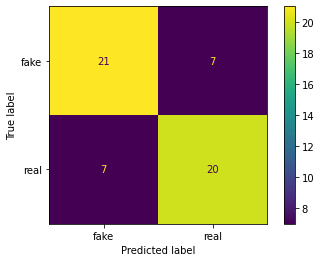

In [136]:
# text and title modified
pp_pa=pp_pass()
pp_pa.fit(Xbt2_train,ybt2_train)
predictionsbt=pp_pa.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionsbt))
plot_confusion_matrix(pp_pa, Xbt2_test, ybt2_test)  
plt.show()

#### Without text preprocessing, let's see how it goes

In [ ]:
# let's see without text preprocessing
# on the title data

              precision    recall  f1-score   support

        fake       0.79      0.82      0.81        28
        real       0.81      0.78      0.79        27

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


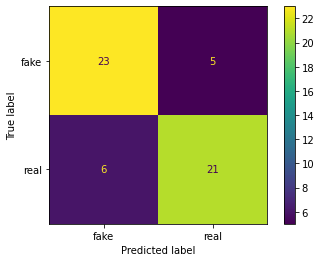

In [174]:
# on the title data
pp_pa = pp_pass()
pp_pa.fit(Xt1_train,yt1_train)
predictionstt1=pp_pa.predict(Xt1_test)

print(classification_report(yt1_test, predictionstt1))
plot_confusion_matrix(pp_pa, Xt1_test, yt1_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.79      0.68      0.73        28
        real       0.71      0.81      0.76        27

    accuracy                           0.75        55
   macro avg       0.75      0.75      0.74        55
weighted avg       0.75      0.75      0.74        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


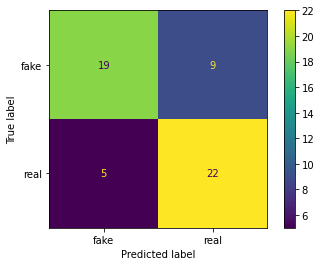

In [177]:
# on the BODY data
pp_pa = pp_pass()
pp_pa.fit(Xb1_train,yb1_train)
predictionstt1=pp_pa.predict(Xb1_test)

print(classification_report(yb1_test, predictionstt1))
plot_confusion_matrix(pp_pa, Xb1_test, yb1_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.84      0.75      0.79        28
        real       0.77      0.85      0.81        27

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


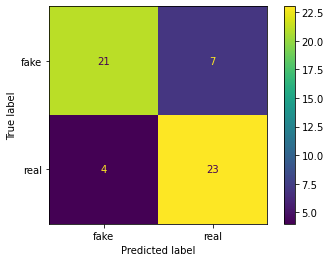

In [178]:
# on the BODY @ title data
pp_pa = pp_pass()
pp_pa.fit(Xbt1_train,ybt1_train)
predictionstt1=pp_pa.predict(Xbt1_test)

print(classification_report(ybt1_test, predictionstt1))
plot_confusion_matrix(pp_pa, Xbt1_test, ybt1_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.84      0.75      0.79        28
        real       0.77      0.85      0.81        27

    accuracy                           0.80        55
   macro avg       0.80      0.80      0.80        55
weighted avg       0.80      0.80      0.80        55



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


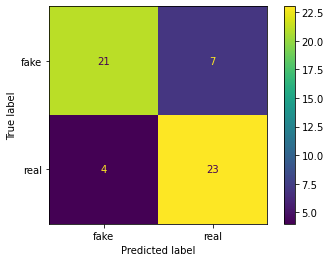

In [220]:
# on the BODY @ title data MODIFIED
pp_pa = pp_pass()
pp_pa.fit(Xbt21_train,ybt21_train)
predictionstt1=pp_pa.predict(Xbt21_test)

print(classification_report(ybt21_test, predictionstt1))
plot_confusion_matrix(pp_pa, Xbt21_test, ybt21_test)  
plt.show()

In [217]:
# params of the passive agressive
pp_pa.get_params()

{'memory': None,
 'steps': [('bow', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('classifier', PassiveAggressiveClassifier())],
 'verbose': False,
 'bow': CountVectorizer(),
 'tfidf': TfidfTransformer(),
 'classifier': PassiveAggressiveClassifier(),
 'bow__analyzer': 'word',
 'bow__binary': False,
 'bow__decode_error': 'strict',
 'bow__dtype': numpy.int64,
 'bow__encoding': 'utf-8',
 'bow__input': 'content',
 'bow__lowercase': True,
 'bow__max_df': 1.0,
 'bow__max_features': None,
 'bow__min_df': 1,
 'bow__ngram_range': (1, 1),
 'bow__preprocessor': None,
 'bow__stop_words': None,
 'bow__strip_accents': None,
 'bow__token_pattern': '(?u)\\b\\w\\w+\\b',
 'bow__tokenizer': None,
 'bow__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'classifier__C': 1.0,
 'classifier__average': False,
 'classifier__class_weight': None,
 'classifier__early_stopping': False,
 'classifier__fit_intercept': True,
 'classi

#### Random Forest recall improvement
we noticed that, for the classification based on title, almost all classifiers have a poor recall score on real and precision on fake data and vice versa. RF also has poor scores for classification based on body for eg as well.
we will try to increase the recall on real news 

In [219]:
pprf.named_steps['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [172]:
# RF parameter tuning
# let's change n_estimators to 200 and random state to 0
def pipeL_rf_200():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier(n_estimators=200, random_state=0 ))
        ])
    return pp

In [205]:
# test on title processed
print("title")
pp200=pipeL_rf_200()
pp200.fit(Xt_train,yt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xt_test)
print(classification_report(yt_test, predictions2))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print("body")
# body preprocesszd
pp200=pipeL_rf_200()
pp200.fit(Xb_train,yb_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xb_test)
print(classification_report(yb_test, predictions2))
#plot_confusion_matrix(pp200, Xb_test, yb_test)  
#plt.show()

print("body and title")
# # text and title processed
pp200=pipeL_rf_200()
pp200.fit(Xbt_train,ybt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt_test)
print(classification_report(ybt_test, predictions2))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()


print("body + body and title")
 # text and title processed modified
pp200=pipeL_rf_200()
pp200.fit(Xbt2_train,ybt2_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt2_test)
print(classification_report(ybt2_test, predictions2))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()



title
              precision    recall  f1-score   support

        fake       0.87      0.46      0.60        28
        real       0.62      0.93      0.75        27

    accuracy                           0.69        55
   macro avg       0.75      0.70      0.68        55
weighted avg       0.75      0.69      0.67        55

body
              precision    recall  f1-score   support

        fake       0.77      0.82      0.79        28
        real       0.80      0.74      0.77        27

    accuracy                           0.78        55
   macro avg       0.78      0.78      0.78        55
weighted avg       0.78      0.78      0.78        55

body and title
              precision    recall  f1-score   support

        fake       0.80      0.86      0.83        28
        real       0.84      0.78      0.81        27

    accuracy                           0.82        55
   macro avg       0.82      0.82      0.82        55
weighted avg       0.82      0.82      0.82     

In [ ]:
# we still feel like the precision and recall of the REAL VALues is still relatively low, ans precision of real low for the title


In [187]:
# RF parameter tuning
# let's change n_estimators to 200 and random state to 0
def pipeL_rf_300():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced_subsample' ))
        ])
    return pp


In [188]:
# test on title processed
pp200=pipeL_rf_300()
pp200.fit(Xt_train,yt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xt_test)
print("title data")
print(classification_report(yt_test, predictions2))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print("body data")
# body preprocesszd
pp200=pipeL_rf_300()
pp200.fit(Xb_train,yb_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xb_test)
print(classification_report(yb_test, predictions2))
#plot_confusion_matrix(pp200, Xb_test, yb_test)  
#plt.show()

print("body and title data")
# # text and title processed
pp200=pipeL_rf_300()
pp200.fit(Xbt_train,ybt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt_test)
print(classification_report(ybt_test, predictions2))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print("body + body and title data")
 # text and title processed modified
pp200=pipeL_rf_300()
pp200.fit(Xbt2_train,ybt2_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt2_test)
print(classification_report(ybt2_test, predictions2))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


title data
              precision    recall  f1-score   support

        fake       0.83      0.36      0.50        28
        real       0.58      0.93      0.71        27

    accuracy                           0.64        55
   macro avg       0.71      0.64      0.61        55
weighted avg       0.71      0.64      0.61        55

body data
              precision    recall  f1-score   support

        fake       0.81      0.93      0.87        28
        real       0.91      0.78      0.84        27

    accuracy                           0.85        55
   macro avg       0.86      0.85      0.85        55
weighted avg       0.86      0.85      0.85        55

body and title data
              precision    recall  f1-score   support

        fake       0.80      0.86      0.83        28
        real       0.84      0.78      0.81        27

    accuracy                           0.82        55
   macro avg       0.82      0.82      0.82        55
weighted avg       0.82      0.82

In [ ]:
# random forest with CV
# Use the random grid to search for best hyperparameters


In [182]:
pp200.named_steps['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [202]:
param_grid = {
     'classifier__n_estimators': [100,200,300,400],
     'classifier__random_state':[0],
     'classifier__class_weight': ['balanced_subsample']
     #'classifier__colsample_bytree': [0.6],
     #'classifier__subsample': [0.5, 0.6, 0.7]
}

In [203]:
# grid search cross validation instantiation
pprf=pipeL_rf()
grid_search = GridSearchCV(estimator = pprf, param_grid = param_grid, 
                          cv = 10, n_jobs = 1, verbose = 0, return_train_score=True)

In [204]:
# test on title processed
print(" ")
print("title data")
grid_search.fit(Xt_train, yt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xt_test)
print(classification_report(yt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print(" ")
print("body data")
# body preprocesszd
grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xb_test)
print(classification_report(yb_test, predictionsrf))

print(" ")
print("body and title data")
# # text and title processed
grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xbt_test)
print(classification_report(ybt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print(" ")
print("body + body and title data")
 # text and title processed modified
grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xbt2_test)
print(classification_report(ybt2_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


 
title data
train scores
[1. 1. 1. 1.]
validation scores
[0.61474359 0.60641026 0.60641026 0.61410256]
{'classifier__class_weight': 'balanced_subsample', 'classifier__n_estimators': 100, 'classifier__random_state': 0}
              precision    recall  f1-score   support

        fake       0.91      0.36      0.51        28
        real       0.59      0.96      0.73        27

    accuracy                           0.65        55
   macro avg       0.75      0.66      0.62        55
weighted avg       0.75      0.65      0.62        55

 
body data
train scores
[1. 1. 1. 1.]
validation scores
[0.73269231 0.76410256 0.74807692 0.75576923]
{'classifier__class_weight': 'balanced_subsample', 'classifier__n_estimators': 200, 'classifier__random_state': 0}
              precision    recall  f1-score   support

        fake       0.80      0.86      0.83        28
        real       0.84      0.78      0.81        27

    accuracy                           0.82        55
   macro avg      